# Pojačavanje (engl. boosting)

Osnovna ideja svih modela pojačavanja (engl. boosting) je da se ansambli grade iterativno dodajući jedan po jedan model koji nadmašuje prethodni. U nastavku ćemo upoznati AdaBoost i XGBoost modele koje ćemo primeniti u zadatku određivanja cena nekretnina koristeći `Boston houses` skup podataka. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from sklearn import model_selection
from sklearn import datasets
from sklearn import preprocessing
from sklearn import metrics

Prvo ćemo učitati podatke i pripremiti skup za treniranje i skup za testiranje. 

In [3]:
data = datasets.load_boston()

In [4]:
# print(data.DESCR)

In [5]:
X = data.data
y = data.target

In [6]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.33, random_state=7)

In [7]:
scaler = preprocessing.StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

## AdaBoost

Ideja `AdaBoost` algoritma je bazirana na promenljivim težinama instanci. Na početku je potrebno nad skupom za treniranje naučiti model klasifikacije ili regresije (takozvani bazni model) dajući podjednak značaj tj. težine svim instancama. Na primer, ako u skupu za treniranje postoji $M$ instanci mogu im se pridružiti težine $\frac{1}{M}$. Potom je potrebno analizirati greške koje je bazni model napravio i proporcionalno njima povećati težine instancama. Na ovaj način se model usmerava da obrati više pažnje na instance sa većim greškama ne bi li postao precizniji. Nad skupom instanci sa novim težinama trenira se sledeći model, a ceo postupak se ponavlja dok se ne dosegne zadati broj modela ansambla. Ovakav pristup sve vreme podržava pojačavanje jer su narednim modelima poznate greške prethodnih modela. 

In [8]:
from sklearn import tree
from sklearn import ensemble

Kao bazni model AdaBoost algoritma odabraćemo regresiono stablo sa maksimalnom dubinom 3. U ansamblu ćemo imati 100 stabala. Uz ovo, preko parametra `loss` možemo precizirati i na koji način će se menjati težine instanci. Na raspolaganju su funkcije `linear`, `square` i `exponential`, a podrazumevana je `linear`.

In [9]:
model_adaboost= ensemble.AdaBoostRegressor(base_estimator=tree.DecisionTreeRegressor(max_depth=3), n_estimators=100, random_state=7)

In [10]:
model_adaboost.fit(X_train, y_train)

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(ccp_alpha=0.0,
                                                       criterion='mse',
                                                       max_depth=3,
                                                       max_features=None,
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                                                       presort='deprecated',
                                                       random_state=None,
                                                       splitter='best'),
                  

In [11]:
y_predict = model_adaboost.predict(X_test)

In [12]:
metrics.mean_squared_error(y_test, y_predict)

14.659910051575515

In [13]:
metrics.r2_score(y_test, y_predict)

0.8068153687596074

Možemo da nacrtamo grafik promene otežane greške u procesu treniranja na osnovu grešaka koje se čuvaju u `estimator_errors` svojstvu.

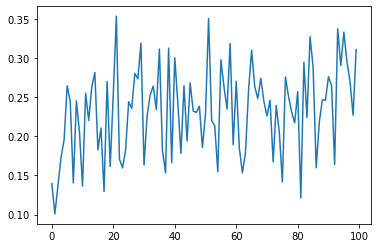

In [14]:
plt.plot(range(0, model_adaboost.n_estimators), model_adaboost.estimator_errors_)
plt.show()

Slično, možemo da prikažemo kako se menja npr. koeficijent determinacije za svaki od modela ansambla u procesu treniranja. 

In [15]:
scores= []
for estimator in model_adaboost.estimators_:
    score = estimator.score(X_train, y_train)
    scores.append(score)

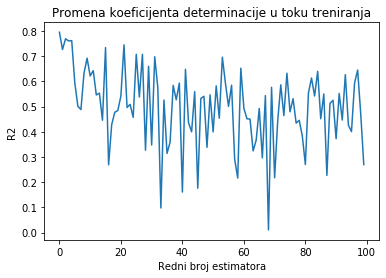

In [16]:
plt.title('Promena koeficijenta determinacije u toku treniranja')
plt.xlabel('Redni broj estimatora')
plt.ylabel('R2')
plt.plot(range(0, model_adaboost.n_estimators), scores)
plt.show()

Na kraju možemo prikazati značajnost pojedinačnih atributa za sam proces treniranja. 

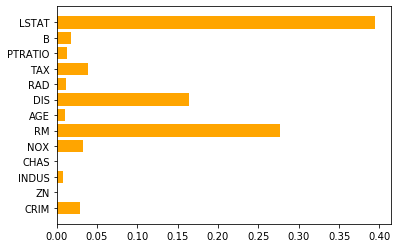

In [17]:
plt.barh(data.feature_names, model_adaboost.feature_importances_, color='orange')
plt.show()

Možete uporediti ove rezultate sa rezultatima koje smo dobili koristeći algoritme za selekciju atributa na uvodnim časovima posvećenim regresiji. 

## XGBoost 

XGBoost (eXtreme Gradient Boosting) je jedan od najpopularnijih algoritama mašinskog učenja. Spada u kategoriju algoritama sa gradijentnim pojačavanjem, a njegova implementacija omogućava paralelizaciju i visoku skalabilnost. Da bismo mogli da kreiramo `XGBoost` modele klasifikacije i regresije, potrebno je da instaliramo `XGBoost` biblioteku. To možemo postići komandom `conda install -c conda-forge xgboost` u skladu sa [zvaničnim smernicama](https://anaconda.org/conda-forge/xgboost).  

XGBoost zajednica radi na razvoju specifičnih algoritama ove grupe (GBDT, GBRT i GBM) i njihovom prilagođavanju različitim jezicima i okruženjima. Zvanični [GitHub repozitorijum](https://github.com/dmlc/xgboost) zajednice sadrži mnoge korisne informacije. 

Osnovna ideja XGBoost algoritma je da polazaći od baznog modela, iterativno, dodajući vektor proporcionalan negativnoj vrednosti gradijenta funkcije koja se minimizuje (simulirajući učenje na prostoru grešaka koji modeli pre njega prave) dođe do optimalnog modela. Funkcija koja se minimizuje u slučaju regresije je najčešće kvadratna greška.  

In [18]:
import xgboost

Modeli koje xgboost biblioteka stavlja na raspolaganje imaju jako puno parametara i podešavanja. Podrazumevani bazni model su stabla odlučivanja pa se jedan deo parametara odnosi na njihova podešavanja, a preostali na samu konstrukciju ansambla i proces treniranja. Ovde ćemo navesti da želimo ansambl koji ima 100 estimatora-stabala maksimalne dubine 3. Takođe, navešćemo da želimo da se u procesu treniranja minimizuje kvadratna greška.  

O ostalim parametrima se više može pročitati u [dokumentaciji](https://xgboost.readthedocs.io/en/latest/parameter.html).

In [19]:
model_xgboost = xgboost.XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=3)

In [20]:
model_xgboost.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.300000012, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
             validate_parameters=False, verbosity=None)

In [21]:
y_predicted = model_xgboost.predict(X_test)

In [22]:
metrics.mean_squared_error(y_test, y_predict)

14.659910051575515

In [23]:
metrics.r2_score(y_test, y_predicted)

0.863422141136677

Modeli dobijeni korišćenjem `xgboost` biblioteke takođe omogućavaju analizu važnosti atributa. Može se uzeti u obzir njihov broj pojavljivanja u stablu odlučivanja (tzv. weight), prosečna vrednost mera kvaliteta na nivou podela u kojima atributi učestvuju (tzv. gain) ili broj instanci obuhvaćenih podelama u kojima atributi učestvuju (tzv. coverage). 

[Text(0, 0, 'CRIM'),
 Text(0, 0, 'ZN'),
 Text(0, 0, 'INDUS'),
 Text(0, 0, 'CHAS'),
 Text(0, 0, 'NOX'),
 Text(0, 0, 'RM'),
 Text(0, 0, 'AGE'),
 Text(0, 0, 'DIS'),
 Text(0, 0, 'RAD'),
 Text(0, 0, 'TAX'),
 Text(0, 0, 'PTRATIO'),
 Text(0, 0, 'B'),
 Text(0, 0, 'LSTAT')]

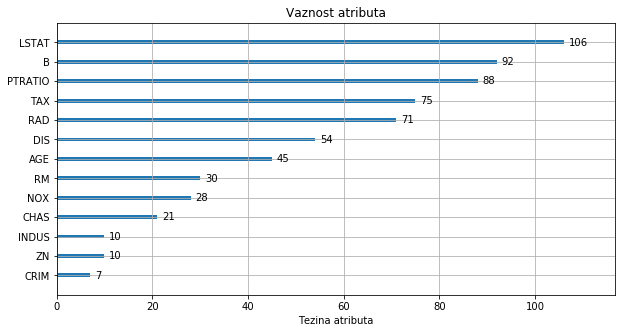

In [24]:
plt.figure(figsize=(10, 5))
ax = plt.subplot(1, 1, 1)
xgboost.plot_importance(model_xgboost, ax= ax, xlabel='Tezina atributa', ylabel=None, title='Vaznost atributa').set_yticklabels(data.feature_names)

Biblioteka `xgboost` omogućava i crtanje pojedinačnih stabala metodom `plot_tree`. Preduslov za njeno korišćenje je postojanje paketa `graphviz` koji se može instalirati komandom `conda install -c anaconda graphviz` u skladu sa [zvaničnim smernicama](https://anaconda.org/anaconda/graphviz). Ovaj paket ćemo koristiti i u radu sa neuronskim mrežama za vizuelizaciju arhitekture mreže. Pregled nekoliko najosnovnijih funkcionalnosti se može naći u [dokumentaciji](https://graphviz.readthedocs.io/en/stable/index.html).

<div class='alert alert-danger'>
    Ukoliko se nakon instalacije graphviz paketa prilikom uvoza pojavi greška <i>No module named 'graphviz'</i>, graphviz paket instalirajte komandom <b>pip install graphviz</b> u baznom okruženju.
</div>

In [25]:
import graphviz

Prilikom iscrtavanja podesićemo dimenzije grafika i njegovu rezoluciju na nivou panela za iscrtavanje. Na ovaj način je stavljeno na raspolaganje deljenje mnogih finih podešavanja. Usmerićemo i  iscrtavanje stabla sa leve ka desnoj strani (`rankdir` parametar).

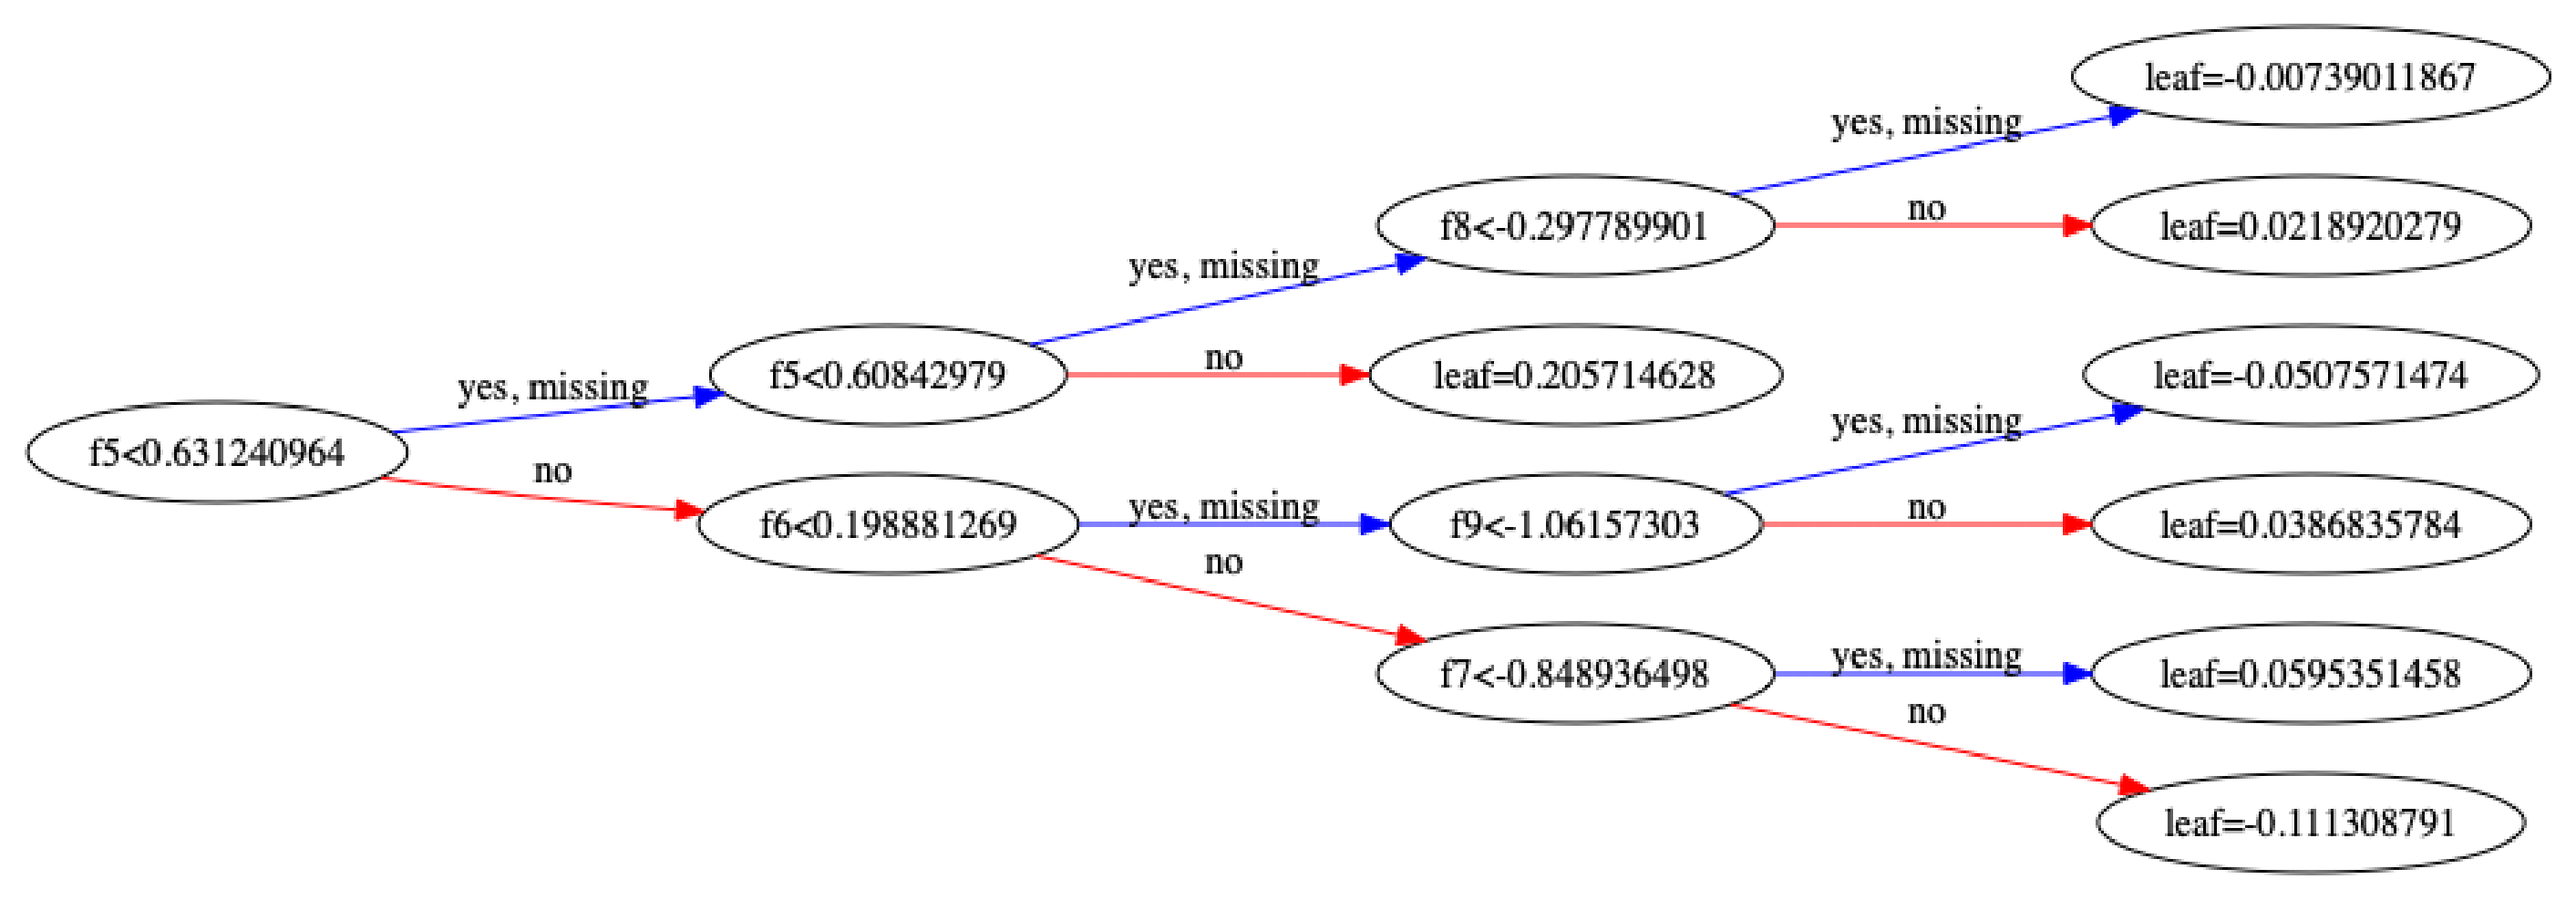

In [26]:
plt.figure(figsize=(20, 15), dpi=180)
ax = plt.subplot(1, 1, 1)
xgboost.plot_tree(model_xgboost, num_trees=99, ax=ax, rankdir='LR')
plt.show()

XGBoost modeli se mogu dodatno ubrzati radom sa specifičnim matricama koje se predstavljaju strukturom `DMatrix`. Za njihovo kreiranje se može koristiti `DMatrix` omotač.

In [27]:
train_data = xgboost.DMatrix(data=X_train, label=y_train, feature_names=data.feature_names)
test_data = xgboost.DMatrix(data=X_test, label=y_test, feature_names=data.feature_names)

Praksa je da se uz ovako pripremljene podatke umesto funkcije `fit` koristi funkcija `train`, a da se za evaluaciju koristi funkcija `eval`. Objedinjeni parametri ovih funkcija zapisani u formi rečnika se prosleđuju funkciji `train`.

In [28]:
xboost_model_dm = xgboost.train({
    'objective':'reg:squarederror', 
    'n_estimators':100, 
    'max_depth':3, 
    'eval_metric':['rmse']}, train_data)

In [29]:
xboost_model_dm.eval(test_data, name='test')

'[0]\ttest-rmse:3.475274'

### Za dalje čitanje: 
- Pregled još nekih zanimljivih modela koji pripadaju ovoj kategoriji: https://www.analyticsvidhya.com/blog/2018/06/comprehensive-guide-for-ensemble-models/
- Shap biblioteka za napredniju analizu i interpretabilnost modela: https://github.com/slundberg/shap